In [10]:
import sys
sys.path.append('/workspace/Documents')
# imports
import os, sys
import numpy as np 
import pandas as pd
import nibabel as nb
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import linregress
from sklearn.metrics import r2_score
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import wilcoxon

import Diffusion_motion_field.functions_collection as ff

main_path = '/mnt/camca_NAS/4DCT/pictures'

In [19]:
def correlation_plot(ef_gt, ef_pred, ef_slope, ef_intercept, save_path, show_plot=False,xlabel = 'Conditioned LVEF (%)', ylabel = 'Model-generated LVEF (%)'):
    plt.figure(figsize=(5,5))
    plt.scatter(ef_gt, ef_pred, color='blue', s=10)
    # fit a dashed line
    a = np.arange(0,101,1)
    plt.plot(a, ef_slope * a + ef_intercept, 'black', linewidth=1)
    plt.plot(a , a, 'black', linewidth=1, linestyle='dashed')

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.grid(True, linestyle='dashed', alpha=0.7, axis = 'both')
    plt.ylim(-0, 100)
    plt.yticks(np.arange(0,101,step = 10),fontsize=13)
    plt.xlim(-0, 100)
    plt.xticks(np.arange(0,101,step = 10),fontsize=13)
    plt.tight_layout()
    if show_plot:
        plt.show()    
    else:
        plt.savefig(save_path)

def bland_plot(ef_gt,ef_pred, save_path, show_plot=False, xlabel = '(Conditioned + Generated) / 2 (%)', ylabel = '(Conditioned - Generated) (%)'):

    measurement1 = ef_pred
    measurement2 = ef_gt
    mean_measurements = np.mean([measurement1, measurement2], axis=0)
    diff_measurements = measurement1 - measurement2

    # Calculate mean and standard deviation of the differences
    mean_diff = np.mean(diff_measurements)
    std_diff = np.std(diff_measurements)

    # Calculate limits of agreement
    loa_upper = mean_diff + 1.96 * std_diff
    loa_lower = mean_diff - 1.96 * std_diff

    print('mean_diff: ',mean_diff)
    print('loa_upper: ', loa_upper )
    print('loa_lower: ', loa_lower)

    # Create the Bland-Altman plot
    plt.figure(figsize=(5,5))
    plt.scatter(mean_measurements, diff_measurements, color='blue', s=10)
    plt.grid(True, linestyle='dashed', alpha=0.7, axis = 'both')

    plt.axhline(mean_diff, color='gray', linestyle='--')
    plt.axhline(loa_upper, color='red', linestyle='--')
    plt.axhline(loa_lower, color='red', linestyle='--')
    plt.xlabel(xlabel,fontsize = 14)
    plt.ylabel(ylabel, fontsize = 14)

    plt.ylim(-30, 31)
    plt.yticks(np.arange(-30,31,step = 10),fontsize=13)
    plt.xlim(-0, 100)
    plt.xticks(np.arange(0,101,step = 20),fontsize=13)
    plt.tight_layout()
    if show_plot:
        plt.show()
    else:
        plt.savefig(save_path)

    return mean_diff, loa_upper, loa_lower


# warp

In [20]:
ef_list = pd.read_excel(os.path.join('/mnt/camca_NAS/4DCT/models/MVF_EDM_down_10tf_imgcon_EFcon_warp_orires/EF_from_warploss_results_epoch1930_edited.xlsx'))
ef_list = ef_list.iloc[:-1]
factual_list = ef_list[ef_list['round_test'] == 0]
counter_list = ef_list[ef_list['round_test'] != 0]
print(factual_list.shape, counter_list.shape)

(40, 6) (120, 6)


### factual

In [21]:
# statistics
# for LVEDV
data = factual_list

# for LVEF
ef_gt = data['preset_EF'] * 100
ef_pred = data['pred_EF'] * 100


# calculate the mae (mean +- std) and bias
ef_mae_mean = np.round(np.mean(np.abs(ef_pred - ef_gt)),3)
ef_mae_std = np.round(np.std(np.abs(ef_pred - ef_gt)),3)
ef_bias_mean = np.round(np.mean(ef_pred - ef_gt),3)
ef_bias_std = np.round(np.std(ef_pred - ef_gt),3)

# calculate the p value 
ef_p = np.round(wilcoxon(ef_gt, ef_pred)[1],3)
# calculate the correlation coefficient
ef_corr, _ = pearsonr(ef_gt, ef_pred)

# Fit linear function to gt vs. pred
ef_slope, ef_intercept, r_value, p_value, std_err = linregress(ef_gt, ef_pred)
ef_r2 = r2_score(ef_gt, ef_pred)

print('for LVEF')
print('mae_mean: ', ef_mae_mean, 'mae_std: ', ef_mae_std, 'bias_mean: ', ef_bias_mean, 'bias_std: ', ef_bias_std, 'p_value: ', ef_p, 'pearson correlation: ', ef_corr,'linear r2', ef_r2,  'slope: ', ef_slope, 'intercept: ', ef_intercept)

for LVEF
mae_mean:  2.443 mae_std:  2.055 bias_mean:  0.162 bias_std:  3.188 p_value:  0.872 pearson correlation:  0.9897574796641787 linear r2 0.9612665416914933 slope:  1.1133423526705346 intercept:  -5.437227539298874


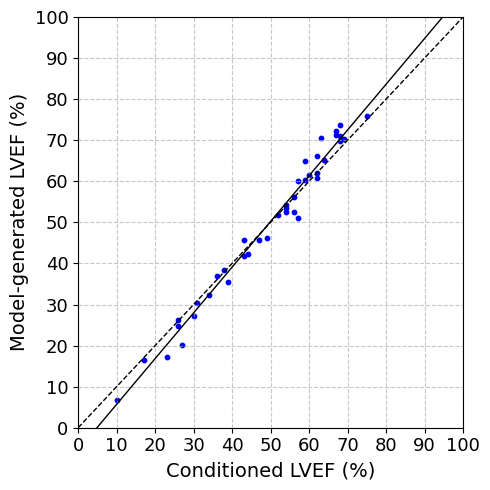

In [22]:
# plot
# dot plot EDV_gt vs. EDV_pred, and fit a linear line
save_path = os.path.join('/mnt/camca_NAS/4DCT/pictures/','LVEF_correlation_ours_factual.pdf')
correlation_plot(ef_gt, ef_pred, ef_slope, ef_intercept, save_path, show_plot=False)

mean_diff:  0.16188468262553216
loa_upper:  6.410621326664224
loa_lower:  -6.08685196141316


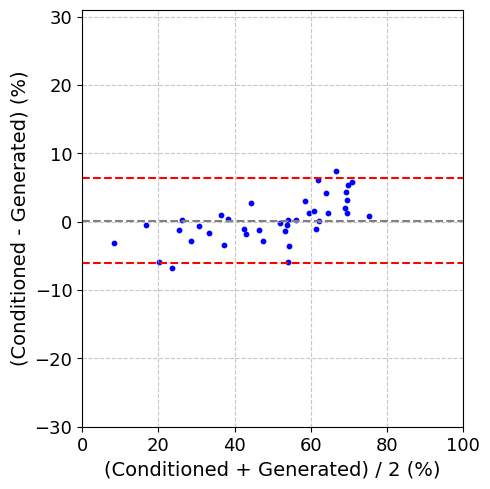

In [23]:
save_path = os.path.join('/mnt/camca_NAS/4DCT/pictures/','LVEF_bland_ours_factual.pdf')
mean_diff, loa_upper, loa_lower = bland_plot(ef_gt, ef_pred, save_path, show_plot=False)


### counterfactual

In [24]:
# statistics
# for LVEDV
data = counter_list

# for LVEF
ef_gt = data['preset_EF'] * 100
ef_pred = data['pred_EF'] * 100


# calculate the mae (mean +- std) and bias
ef_mae_mean = np.round(np.mean(np.abs(ef_pred - ef_gt)),3)
ef_mae_std = np.round(np.std(np.abs(ef_pred - ef_gt)),3)
ef_bias_mean = np.round(np.mean(ef_pred - ef_gt),3)
ef_bias_std = np.round(np.std(ef_pred - ef_gt),3)

# calculate the p value 
ef_p = np.round(wilcoxon(ef_gt, ef_pred)[1],3)
# calculate the correlation coefficient
ef_corr, _ = pearsonr(ef_gt, ef_pred)

# Fit linear function to gt vs. pred
ef_slope, ef_intercept, r_value, p_value, std_err = linregress(ef_gt, ef_pred)
ef_r2 = r2_score(ef_gt, ef_pred)

print('for LVEF')
print('mae_mean: ', ef_mae_mean, 'mae_std: ', ef_mae_std, 'bias_mean: ', ef_bias_mean, 'bias_std: ', ef_bias_std, 'p_value: ', ef_p, 'pearson correlation: ', ef_corr,'linear r2', ef_r2,  'slope: ', ef_slope, 'intercept: ', ef_intercept)

for LVEF
mae_mean:  2.508 mae_std:  1.931 bias_mean:  -0.671 bias_std:  3.093 p_value:  0.016 pearson correlation:  0.9952109461575658 linear r2 0.9738940654257792 slope:  1.1138620964977284 intercept:  -5.792561222508027


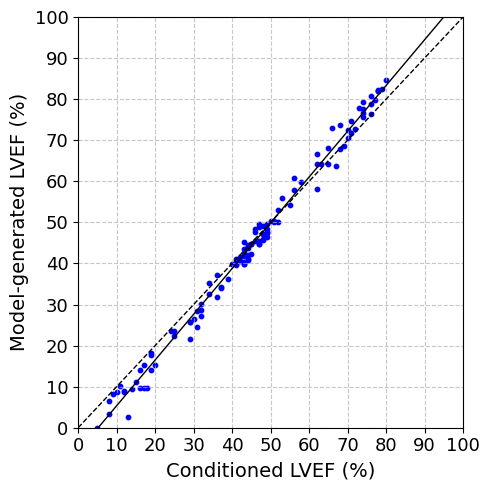

In [25]:
# plot
# dot plot EDV_gt vs. EDV_pred, and fit a linear line
save_path = os.path.join('/mnt/camca_NAS/4DCT/pictures/','LVEF_correlation_ours_counter.pdf')
correlation_plot(ef_gt, ef_pred, ef_slope, ef_intercept, save_path, show_plot=False)

mean_diff:  -0.6706645817185447
loa_upper:  5.392431351312721
loa_lower:  -6.733760514749811


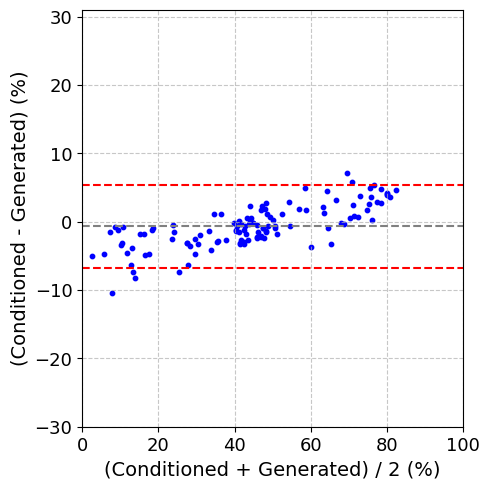

In [26]:
save_path = os.path.join('/mnt/camca_NAS/4DCT/pictures/','LVEF_bland_ours_counter.pdf')
mean_diff, loa_upper, loa_lower = bland_plot(ef_gt, ef_pred, save_path, show_plot=False)


# EF predictor

In [48]:
from_ef_predictor_loss = False
if from_ef_predictor_loss:
    ef_list = pd.read_excel(os.path.join('/mnt/camca_NAS/4DCT/models/MVF_EDM_down_10tf_imgcon_EFcon_EFpredict_trial2/EF_from_EFpredictor_results_epoch1410_edited.xlsx'))
else:
    ef_list = pd.read_excel(os.path.join('/mnt/camca_NAS/4DCT/models/MVF_EDM_down_10tf_imgcon_EFcon_EFpredict_trial2/EF_from_warploss_results_epoch1410_edited.xlsx'))

ef_list = ef_list.iloc[:-1]
factual_list = ef_list[ef_list['round_test'] == 0]
counter_list = ef_list[ef_list['round_test'] != 0]
print(factual_list.shape, counter_list.shape)

(40, 6) (120, 6)


### factual

In [49]:
# statistics
# for LVEDV
data = factual_list

# for LVEF
ef_gt = data['preset_EF'] * 100
ef_pred = data['pred_EF'] * 100


# calculate the mae (mean +- std) and bias
ef_mae_mean = np.round(np.mean(np.abs(ef_pred - ef_gt)),3)
ef_mae_std = np.round(np.std(np.abs(ef_pred - ef_gt)),3)
ef_bias_mean = np.round(np.mean(ef_pred - ef_gt),3)
ef_bias_std = np.round(np.std(ef_pred - ef_gt),3)

# calculate the p value 
ef_p = np.round(wilcoxon(ef_gt, ef_pred)[1],3)
# calculate the correlation coefficient
ef_corr, _ = pearsonr(ef_gt, ef_pred)

# Fit linear function to gt vs. pred
ef_slope, ef_intercept, r_value, p_value, std_err = linregress(ef_gt, ef_pred)
ef_r2 = r2_score(ef_gt, ef_pred)

print('for LVEF')
print('mae_mean: ', ef_mae_mean, 'mae_std: ', ef_mae_std, 'bias_mean: ', ef_bias_mean, 'bias_std: ', ef_bias_std, 'p_value: ', ef_p, 'pearson correlation: ', ef_corr,'linear r2', ef_r2,  'slope: ', ef_slope, 'intercept: ', ef_intercept)

for LVEF
mae_mean:  12.244 mae_std:  6.328 bias_mean:  -12.244 bias_std:  6.328 p_value:  0.0 pearson correlation:  0.9313040711562468 linear r2 0.28173748173980273 slope:  0.7397722982623401 intercept:  0.6830632541723816


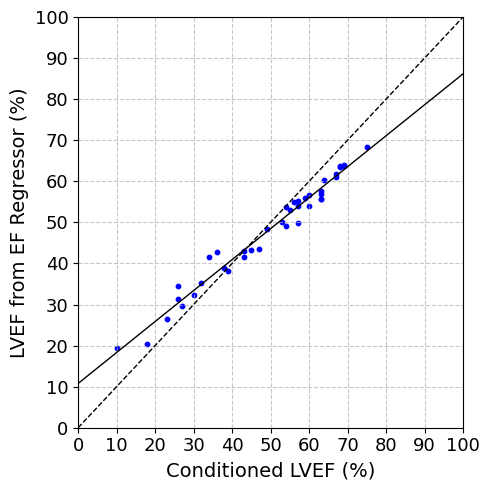

In [43]:
# plot
# dot plot EDV_gt vs. EDV_pred, and fit a linear line
if from_ef_predictor_loss:
    save_path = os.path.join('/mnt/camca_NAS/4DCT/pictures/','LVEF_correlation_EFpredictor_factual_forEFpredictor.pdf')
    correlation_plot(ef_gt, ef_pred, ef_slope, ef_intercept, save_path, show_plot=False, xlabel = 'Conditioned LVEF (%)', ylabel = 'LVEF from EF Regressor (%)')
else:
    save_path = os.path.join('/mnt/camca_NAS/4DCT/pictures/','LVEF_correlation_EFpredictor_factual.pdf')
    correlation_plot(ef_gt, ef_pred, ef_slope, ef_intercept, save_path, show_plot=False)

mean_diff:  -1.4462981253862377
loa_upper:  7.381988456319097
loa_lower:  -10.274584707091572


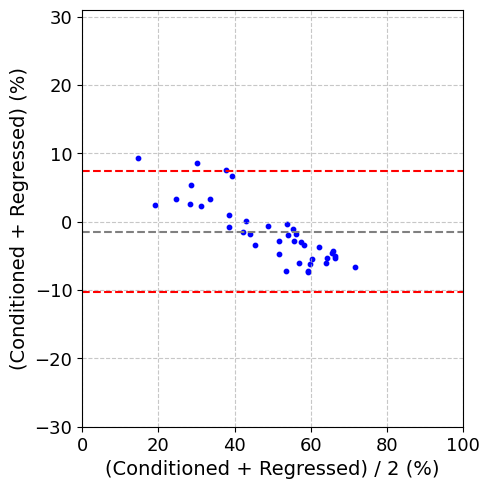

In [44]:
# plot
# dot plot EDV_gt vs. EDV_pred, and fit a linear line
if from_ef_predictor_loss:
    save_path = os.path.join('/mnt/camca_NAS/4DCT/pictures/','LVEF_bland_EFpredictor_factual_forEFpredictor.pdf')
    mean_diff, loa_upper, loa_lower = bland_plot(ef_gt, ef_pred, save_path, show_plot=False, xlabel = '(Conditioned + Regressed) / 2 (%)', ylabel = '(Conditioned + Regressed) (%)')
else:
    save_path = os.path.join('/mnt/camca_NAS/4DCT/pictures/','LVEF_bland_EFpredictor_factual.pdf')
    mean_diff, loa_upper, loa_lower = bland_plot(ef_gt, ef_pred, save_path, show_plot=False)


### Counterfactual

In [50]:
# statistics
# for LVEDV
data = counter_list

# for LVEF
ef_gt = data['preset_EF'] * 100
ef_pred = data['pred_EF'] * 100


# calculate the mae (mean +- std) and bias
ef_mae_mean = np.round(np.mean(np.abs(ef_pred - ef_gt)),3)
ef_mae_std = np.round(np.std(np.abs(ef_pred - ef_gt)),3)
ef_bias_mean = np.round(np.mean(ef_pred - ef_gt),3)
ef_bias_std = np.round(np.std(ef_pred - ef_gt),3)

# calculate the p value 
ef_p = np.round(wilcoxon(ef_gt, ef_pred)[1],3)
# calculate the correlation coefficient
ef_corr, _ = pearsonr(ef_gt, ef_pred)

# Fit linear function to gt vs. pred
ef_slope, ef_intercept, r_value, p_value, std_err = linregress(ef_gt, ef_pred)
ef_r2 = r2_score(ef_gt, ef_pred)

print('for LVEF')
print('mae_mean: ', ef_mae_mean, 'mae_std: ', ef_mae_std, 'bias_mean: ', ef_bias_mean, 'bias_std: ', ef_bias_std, 'p_value: ', ef_p, 'pearson correlation: ', ef_corr,'linear r2', ef_r2,  'slope: ', ef_slope, 'intercept: ', ef_intercept)

for LVEF
mae_mean:  12.272 mae_std:  8.087 bias_mean:  -12.214 bias_std:  8.175 p_value:  0.0 pearson correlation:  0.9409638017953136 linear r2 0.43717791950286233 slope:  0.6557929839174332 intercept:  3.2700146799343273


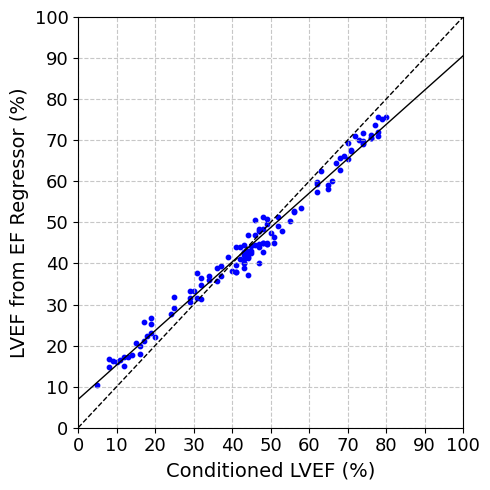

In [46]:
# plot
# dot plot EDV_gt vs. EDV_pred, and fit a linear line
if from_ef_predictor_loss:
    save_path = os.path.join('/mnt/camca_NAS/4DCT/pictures/','LVEF_correlation_EFpredictor_counter_forEFpredictor.pdf')
    correlation_plot(ef_gt, ef_pred, ef_slope, ef_intercept, save_path, show_plot=False, xlabel = 'Conditioned LVEF (%)', ylabel = 'LVEF from EF Regressor (%)')
else:
    save_path = os.path.join('/mnt/camca_NAS/4DCT/pictures/','LVEF_correlation_EFpredictor_counter.pdf')
    correlation_plot(ef_gt, ef_pred, ef_slope, ef_intercept, save_path, show_plot=False)

mean_diff:  -0.4549824908375736
loa_upper:  7.2921763517799265
loa_lower:  -8.202141333455074


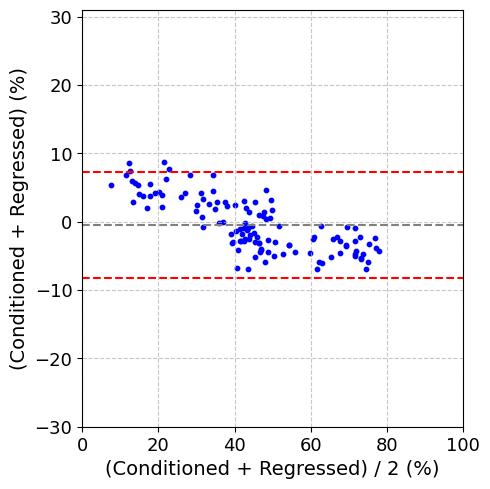

In [47]:
# plot
# dot plot EDV_gt vs. EDV_pred, and fit a linear line
if from_ef_predictor_loss:
    save_path = os.path.join('/mnt/camca_NAS/4DCT/pictures/','LVEF_bland_EFpredictor_counter_forEFpredictor.pdf')
    mean_diff, loa_upper, loa_lower = bland_plot(ef_gt, ef_pred, save_path, show_plot=False, xlabel = '(Conditioned + Regressed) / 2 (%)', ylabel = '(Conditioned + Regressed) (%)')
else:
    save_path = os.path.join('/mnt/camca_NAS/4DCT/pictures/','LVEF_bland_EFpredictor_counter.pdf')
    mean_diff, loa_upper, loa_lower = bland_plot(ef_gt, ef_pred, save_path, show_plot=False)


## Vanilla

In [35]:
ef_list = pd.read_excel(os.path.join('/mnt/camca_NAS/4DCT/models/MVF_EDM_down_10tf_imgcon_EFcon/EF_from_warploss_results_epoch2350_edited.xlsx'))
ef_list = ef_list.iloc[:-1]
factual_list = ef_list[ef_list['round_test'] == 0]
counter_list = ef_list[ef_list['round_test'] != 0]
print(factual_list.shape, counter_list.shape)

(40, 6) (120, 6)


In [36]:
# statistics
# for LVEDV
data = factual_list

# for LVEF
ef_gt = data['preset_EF'] * 100
ef_pred = data['pred_EF'] * 100


# calculate the mae (mean +- std) and bias
ef_mae_mean = np.round(np.mean(np.abs(ef_pred - ef_gt)),3)
ef_mae_std = np.round(np.std(np.abs(ef_pred - ef_gt)),3)
ef_bias_mean = np.round(np.mean(ef_pred - ef_gt),3)
ef_bias_std = np.round(np.std(ef_pred - ef_gt),3)

# calculate the p value 
ef_p = np.round(wilcoxon(ef_gt, ef_pred)[1],3)
# calculate the correlation coefficient
ef_corr, _ = pearsonr(ef_gt, ef_pred)

# Fit linear function to gt vs. pred
ef_slope, ef_intercept, r_value, p_value, std_err = linregress(ef_gt, ef_pred)
ef_r2 = r2_score(ef_gt, ef_pred)

print('for LVEF')
print('mae_mean: ', ef_mae_mean, 'mae_std: ', ef_mae_std, 'bias_mean: ', ef_bias_mean, 'bias_std: ', ef_bias_std, 'p_value: ', ef_p, 'pearson correlation: ', ef_corr,'linear r2', ef_r2,  'slope: ', ef_slope, 'intercept: ', ef_intercept)

for LVEF
mae_mean:  12.454 mae_std:  7.113 bias_mean:  -4.488 bias_std:  13.622 p_value:  0.05 pearson correlation:  0.5475839507050616 linear r2 0.22220822218666103 slope:  0.278764657095018 intercept:  31.339456927404015


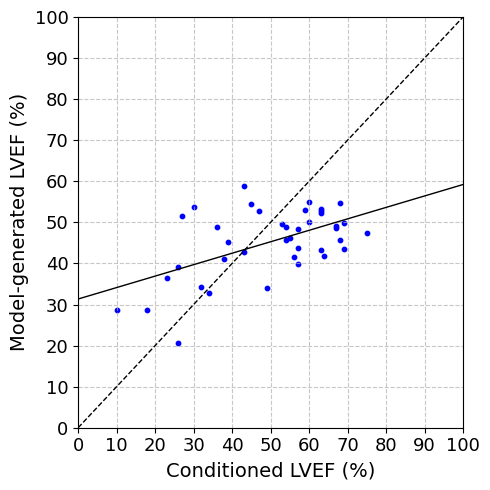

In [37]:
# plot
# dot plot EDV_gt vs. EDV_pred, and fit a linear line
save_path = os.path.join('/mnt/camca_NAS/4DCT/pictures/','LVEF_correlation_none_factual.pdf')
correlation_plot(ef_gt, ef_pred, ef_slope, ef_intercept, save_path, show_plot=False)

In [38]:
# statistics
# for LVEDV
data = counter_list

# for LVEF
ef_gt = data['preset_EF'] * 100
ef_pred = data['pred_EF'] * 100


# calculate the mae (mean +- std) and bias
ef_mae_mean = np.round(np.mean(np.abs(ef_pred - ef_gt)),3)
ef_mae_std = np.round(np.std(np.abs(ef_pred - ef_gt)),3)
ef_bias_mean = np.round(np.mean(ef_pred - ef_gt),3)
ef_bias_std = np.round(np.std(ef_pred - ef_gt),3)

# calculate the p value 
ef_p = np.round(wilcoxon(ef_gt, ef_pred)[1],3)
# calculate the correlation coefficient
ef_corr, _ = pearsonr(ef_gt, ef_pred)

# Fit linear function to gt vs. pred
ef_slope, ef_intercept, r_value, p_value, std_err = linregress(ef_gt, ef_pred)
ef_r2 = r2_score(ef_gt, ef_pred)

print('for LVEF')
print('mae_mean: ', ef_mae_mean, 'mae_std: ', ef_mae_std, 'bias_mean: ', ef_bias_mean, 'bias_std: ', ef_bias_std, 'p_value: ', ef_p, 'pearson correlation: ', ef_corr,'linear r2', ef_r2,  'slope: ', ef_slope, 'intercept: ', ef_intercept)

for LVEF
mae_mean:  15.947 mae_std:  11.617 bias_mean:  0.271 bias_std:  19.728 p_value:  0.787 pearson correlation:  0.18413980659277235 linear r2 -0.01425279627345355 slope:  0.07423714805751647 intercept:  41.91533775485443


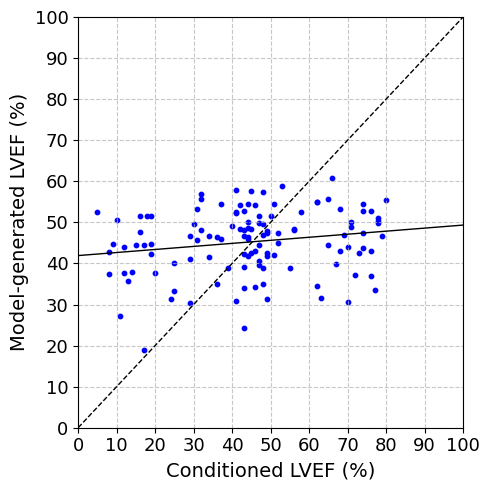

In [39]:
# plot
# dot plot EDV_gt vs. EDV_pred, and fit a linear line
save_path = os.path.join('/mnt/camca_NAS/4DCT/pictures/','LVEF_correlation_none_counter.pdf')
correlation_plot(ef_gt, ef_pred, ef_slope, ef_intercept, save_path, show_plot=False)